<center>
    <img src="https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/adsp_logo.png?raw=1">
</center>

### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta


In [1]:
# Configurations for Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !git clone https://github.com/GuitarsAI/ADSP_Tutorials.git
    path="./ADSP_Tutorials"
else:
    print('Not running on CoLab')
    path="."

Running on CoLab
Cloning into 'ADSP_Tutorials'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 300 (delta 0), reused 0 (delta 0), pack-reused 297 (from 1)
Receiving objects: 100% (300/300), 105.19 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Updating files: 100% (71/71), done.


# Vector Quantizer (VQ) and Linde-Buzo-Gray (LBG) Algorithm

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/UKJ2sXqjsro" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Remember, The Lloyd-Max iteration could look like the following:

1) Start (initialize the iteration) with a random  	assignment of M reconstruction values 	(codewords) $y_k$ .<br>
2) Using the reconstruction values, compute the boundary values $b_k$ as mid-points between 2 reconstruction values / codewords (**nearest neighbour rule**).<br>
3) Using the pdf of our signal and the boundary values, compute new reconstruction values (codewords) $y_k$ as centroids over the quantisation areas (**conditional expectation/centroid**).<br>
4) Go to 2) until update is sufficiently small (< epsilon).
      
This algorithm usually converges (it finds an equilibrium and doesn't change anymore), and it results in the minimum distortion D.

It is interesting that this can be generalized to the multidimensional case, to the so-called Vector Quantization.

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/j0CNR9C40K0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Vector Quantization

**Scalar** quantization usually makes the assumption that the signal to quantize, the source, is **memoryless**, which means each sample is statistically independent of any other sample in the sequence. This can be seen as having no “memory” between the samples. Examples of these sources might be: Thermal noise, white noise, or a sequence of dice tosses, lottery numbers.

But many signals do **have memory**, they have samples which are statistically dependent on other samples in the sequence. Example are: Speech signals, pink noise (noise which has a non-flat spectrum), temperature values over the year, image signals, audio signals.

Since many signals of interest indeed have memory, this suggests that we can do a better job. One possible approach to deal with memory (statistical dependencies) in our signal, is to use the so-called **Vector Quantization (VQ)**.
A possible **reference** is: **“Introduction to Data Compression”**, Section about Vector Quantisation, by Khalid Sayood, Morgan Kaufmann publishers

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/emn_LLIprjA" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

How does VQ work? Instead of quantizing each scalar value (each sample) individually, we first group the sequence of samples x(n) into groups of N samples:

$$[x(0),...,x(N-1)],[x(N),...,X(2N-1)],[x(2N),..,x(3N-1)],...$$

In this way we obtain a sequence of blocks (also called **vectors**) of size **N samples** each. In this way we obtain a sequence of samples in an **N-dimensional** space. In such a way we can capture or use the memory between samples within each block or vector. The resulting samples with memory in the N-dimensional space will then lie on or near a **hyperplane** or subspace within this N-dimensional space. Hence we don't need to sample the entire space, but we only need to sample the part of our space where our samples are actually located.

**Example:** Take correlated samples, such that one sample is always similar to the previous sample, just like in a sequence of speech or audio samples (usually we don't have very high frequencies there, and that means the curve through the samples is more or less smooth).

Now take the dimension N=2. Then we obtain a 2-dimensional vector space of samples, which could look like in the following diagram. The resulting sequence of vectors is:

$$[x(0),x(1)],[x(2),x(3)],[x(4),x(5)],...$$

For instance, our signal could be: $x=[23,45,21,4,-23,-4]$, then we get the following **sequence of vectors:**
$[23,45]; [21,4]; [-23,-4]$

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Xk34acyQYrw" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Python Example:

In [2]:
# Imports
import librosa as lbr
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd


In [3]:
# Signal Processing Parameters
Fs = 32000   # Sampling frequency
T=1/Fs       # Sampling Period
t = np.arange(Fs)*T # Time vector 1 second

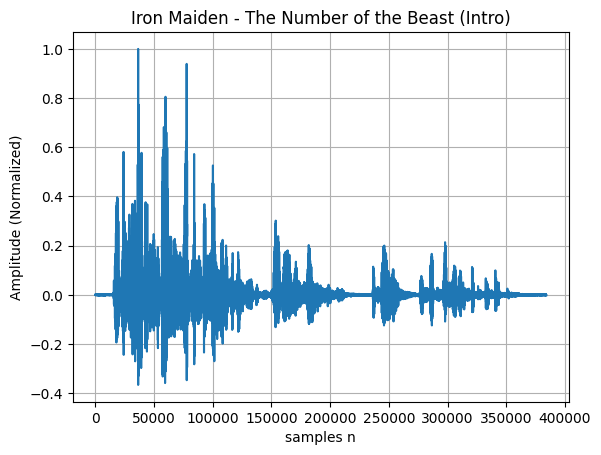

In [25]:
# Load audio file
speech_signal , sr =lbr.load(path+'/audio/Iron Maiden - The Number Of The Beast.mp3', sr=Fs, offset=13, duration=12)
#help(lbr.load)
# Normalize Audio
speech_signal/=np.abs(speech_signal).max()
# Plot Audio
plt.figure()
plt.plot(speech_signal)
plt.title('Iron Maiden - The Number of the Beast (Intro)')
plt.xlabel('samples n')
plt.ylabel('Amplitude (Normalized)');
plt.grid()
# Listen
display(ipd.Audio(speech_signal, rate = Fs ))

Now plot the 2 dimensional vectors, with their sample values of even indices on the x axes, and their sample values of odd indices on the y axis. Each such pair is plotted as a ‘+’:

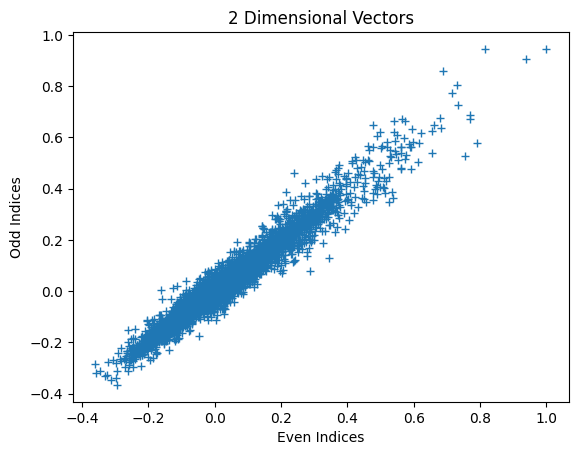

In [26]:
plt.figure()
plt.plot(speech_signal[2::2], speech_signal[1:-1:2], '+')
plt.title('2 Dimensional Vectors')
plt.xlabel('Even Indices')
plt.ylabel('Odd Indices');

We can see: Since the odd and the even samples are similar to each other, we get a distribution of vector points near the **diagonal** of the space! Hence we also need to sample this space only near the diagonal, or more generally speaking, we should sample more densely near this diagonal.

This shows that we need **fewer** reconstruction values or **codewords** as in the 1-dimensional case, which means fewer indices for them, and hence **fewer bits** for the quantized signal.

Vector **Encoder** : Dividing our signal into signal vectors, find the nearest codeword, transmit its index to the decoder:<br>
Vector **Decoder**: Read out the codevector from the codebook using the index from the encoder, **concatenate** the sequence of codevectors into a sample stream.

An interesting property is that vector quantizers not only give an advantage for signals with memory, but also for signals without memory. In the scalar case, we can only sample an N-dimensional space on a regular grid, which is given by the coordinate axis of this space, whereas with VQ we can use something like a densest sphere packing in this N-dimensional space, such that we reduce the distance between reconstruction vectors (the so-called **codewords**), and hence reduce the Expectation of the quantisation error even in this case.

The following image illustrates the densest sphere packing for the case of memoryless signals:<br>
<br>

<center>
    The case of a scalar quantizer:<br>
    <img src="https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/sphere_dense_1.PNG?raw=1" width="400">
    The case of a vector quantizer with N=2:
    <img src="https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/sphere_dense_2.PNG?raw=1" width="400">
</center>

Observe that in this way we get a denser “packing”, shifting the spheres in the gaps of the neighbouring layers, which results in a reduced reconstruction error.

How do we do the **quantization in the N-dimensional case** in general? We choose N-dimensional reconstruction values, which we now call **codewords**.

We use the **nearest neighbour** rule to map each N-dimensional **signal vector to** the **nearest codevector**. You could think of it as the neighbourhood as n-dimensional spheres around each codevector. Each codevector has an index  and this index is then transmitted to the receiver, which uses this codevector as a reconstruction value. The collection of all codewords is called a **codebook**. The size of the codebook also determines how many bits are needed for their index. Usually codebooks are fixed, pre-defined, but there are also adaptive codebooks, for instance in speech coding.

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/5_1Y3i2b8xQ" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

So how do we **obtain our codebook**, our codevectors?

Basically like in the Lloyd-Max case, we are just extending it to the N-dimensional case. For N-dimensional case this is called the **Linde-Buzo-Gray (LBG)** Algorithm (see also the Book Introduction to Data Compression):

This could look like the following:

1) Start (**initialize** the iteration) with a **random** assignment of M  N-dimensional **codewords**, $\boldsymbol y_k$(bold-face to indicate a vector).

2) Using the codewords, compute the **decision boundary** $\boldsymbol b_k$(bold face to indicate that a line or hyper-plane) as the set of **all** points with equal distance between 2 reconstruction values / codewords (the such constructed regions are also called **Voronoi-regions**), using the **nearest neighbour** rule. To assign a vector to a specific region, we use the nearest neighbour rule directly. We simply test which **codeword is closest** to the observed vector.

3) Using the pdf of our signal and the decision boundary (Voronoi region), compute new **codewords** $\boldsymbol y_k$ as **centroids (center of mass) or conditional expectation** over the quantisation areas (the Voronoi region). The same as in 1 dimension, just here the integral is going over N dimension.

4) Go to 2) until update is sufficiently small (< epsilon).

Here we assume we have a pdf of the signal. Observe that here we would need a **multi dimensional pdf or probability distribution**, which is difficult to obtain, since the volume of the space increases exponentially with its dimension, but the number of vectors rather decreases. Hence we get less dense signal points in high dimensional space, which means a pdf is difficult to estimate.

Hence, instead of a multi dimensional pdf, we often only have a so-called **training set** to obtain our codebook. The training set is a set of signals which have statistics like our targeted signals, but which are **only** used to “train” (using LBG) our codebook vectors. To **test** resulting vector quantizer, we should use signals which are **not** in the training set.

We can still use this same algorithm as with the pdf, we just have to compute the **centroid** or conditional expectation differently. Assume we have L samples in our Voronoi neighbourhood region, and want to compute the centroid of this Voronoi region. We could do that by assigning each signal vector **x(k)** of the training set to a probability of 1/L (we assume each vector is equally likely), and then just use the above formula for the centroid, replacing the integrals by sums. This then results in

$$
\boldsymbol y_k =\frac {\sum _{ i \in Voronoi region k }  \boldsymbol x(i)}  {Number of signal vectors \in Voronoi region}
$$

This is simply the **average** of all **observed training vectors** in our Voronoi region. The sum contains the indices I of signal vevtors x(i) which are closest to codevector k. <br>
This is then part of our iteration.

After training the codebook with the training set (only for training or learning to obtain the codebook), we have a (fixed) codebook which we can then use for encoding our data. Observe that the training set should be different from our data.<br>
The resulting Vector Quantizer could look like in following image for dimension N=2, where the blue lines are the boundaries of the Voronoi regions (consisting of our $\boldsymbol b_k$), the red stars are the codevectors $\boldsymbol y_k$, and the green dots the signal vectors:<br>

<center>
    <img src="https://github.com/GuitarsAI/ADSP_Tutorials/blob/master/images/voronoi.png?raw=1">
    <font size='2'>
(From: http://www.data-compression.com/vq.html)
</font>
</center>



**Example.** Determine the codebook vectors of a LBG vector quantizer for dimension N=2, and number of codevectors M=2, after one iteration for two vectors with the given training set **x** = [3,2,4,5,7,8,8,9]. Initial codebook vectors are y1=[1,2], y2 =[5,6].

The training set vectors are hence: [3,2], [4,5], [7,8], [8,9].

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/22BOHRxn03g" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

The solution follows the algorithm which was explained in the lecture:

1) We start with the given **randomly assigned codebook vectors $\boldsymbol y_k$**.

2) The next step is to calculate **decision boundary** $\boldsymbol b_k$ using the **nearest neighbour** rule to obtain the Voronoi region. This results in a set of midpoints. These mid-points then form  the Voronoi boundary line, which is perpendicular to the connecting line of the 2 codewords. The direct mid-point is: <br>
$$\boldsymbol b_k=\frac{\boldsymbol y_1+ \boldsymbol y_2}{2}$$

$\boldsymbol b_k$ in our case is  the line going through the point [3,4], the line consisting of **all points** which have **equal distance** to the neighboring codevectors. Now we can draw the given training set vectors, codebook vectors, and the Voronoi boundaries. Observe that the computation of the **boundary line** of the mid-points is useful only for drawing this picture, but in a computational implementation we don't need to compute it, but use the nearest neighbour rule directly.

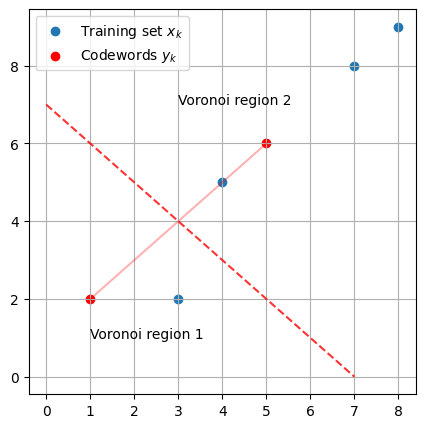

In [27]:
# Python Plot
plt.figure(figsize=(5,5))
train=np.array([[3,2], [4,5], [7,8],[8,9]])
codebooks = np.array([[1,2], [5,6]])
x_train, y_train = train.T
x_codebooks, y_codebooks = codebooks.T
plt.scatter(x_train, y_train, label='Training set $x_k$')
plt.scatter(x_codebooks, y_codebooks, label='Codewords $y_k$',color='r')
plt.legend()
plt.grid()
y=lambda x : -x+7
plt.plot([1,5],[2,6],color='r', alpha=0.3)
plt.plot(np.arange(0,8,1),y(np.arange(0,8,1)),'r--', alpha=0.8)
plt.text(1,1,'Voronoi region 1')
plt.text(3,7,'Voronoi region 2');

3) The next step is to compute the new **codewords** $\boldsymbol y_k$ as a **centroid or conditional expectation** over a quantization area or Voronoi region. In order to do that, the formula for the trainings set from the lecture should be used:<br>

$$
\boldsymbol y_k= \frac {\sum _{i \in Voronoiregion k} \boldsymbol x(i)}{Number of signal vectors \in Voronoiregion}
$$


In order to find out in **which Voronoi region** a vector is located, we use the nearest neighbour rule. For that we need to calculate the **Euclidean distances** between all the **training set vectors** and **codebook vectors** and then decide which training vectors are closer to which codebook vector.

For each training set vector we compute to which codebook vector it has the closest distance, with the Euclidean distances calculated in the following way:

<ul>
    <li> For trainigs set vector $\boldsymbol x_1=[3,2]$:
        <ul>
            <li> distance to codebook vector $\boldsymbol y_1=[1,2]$: $d_1=\sqrt{(3-1)^2+(2-2)^2}=\sqrt{4}$ </li>
            <li> distance to codebook vector $\boldsymbol y_2 =[5,6]$: $d_2=\sqrt{(3-5)^2+(2-6)^2}=\sqrt{20}$
            <br> Hence  $\boldsymbol y_1$ is closer. </li>
        </ul> </li>
    <li> For trainigs set vector $\boldsymbol x_2=[4,5]$:
        <ul>
            <li> distance to codebook vector $\boldsymbol y_1=[1,2]$: $d_1=\sqrt{(4-1)^2+(5-2)^2}=\sqrt{18}$</li>
            <li> distance to codebook vector $\boldsymbol y_2 =[5,6]$: $d_2=\sqrt{(5-4)^2+(6-5)^2}=\sqrt{2}$
            <br> Hence $\boldsymbol y_2$ is closer. </li>
        </ul> </li>
    <li> For trainigs set vector $\boldsymbol x_3=[7,8]$:
        <ul>
            <li> distance to codebook vector $\boldsymbol y_1=[1,2]$: $d_1=\sqrt{(7-1)^2+(8-2)^2}=\sqrt{72}$</li>
            <li> distance to codebook vector $\boldsymbol y_2 =[5,6]$: $d_2=\sqrt{(7-5)^2+(8-6)^2}=\sqrt{8}$
            <br> Hence $\boldsymbol y_2$ is closer. </li>
        </ul> </li>
    <li> For trainigs set vector $\boldsymbol x_4=[8,9]$:
        <ul>
            <li> distance to codebook vector $\boldsymbol y_1=[1,2]$: $d_1=\sqrt{(8-1)^2+(9-2)^2}=\sqrt{98}$</li>
            <li> distance to codebook vector $\boldsymbol y_2 =[5,6]$: $d_2=\sqrt{(8-5)^2+(9-6)^2}=\sqrt{18}$
            <br> Hence $\boldsymbol y_2$ is closer. </li>
        </ul> </li>
</ul>

     
Now we can compute the **centroid or conditional expectation** for each of the 2 Voronoi regions:

- **Voronoi region 1** only contains trainings set vector $\boldsymbol x1=[3,2]$, hence its centroid and new codebook vector is identical to $\boldsymbol x_1$ and we get the **new codebook vector 1** as:

$$\boldsymbol y_1=[3,2]$$

- **Voronoi region 2** contains the remaining 3 vectors. We obtain its centroid by averaging over them, and obtain the **new codebook vector 2** as:     

$$
\boldsymbol y_2=[\frac{4+7+8}{3}, \frac{5+8+9}{3}]=[6+\frac{1}{3}, 7+\frac{1}{3}]
$$

So the updated codebook vectors will look in the following way:

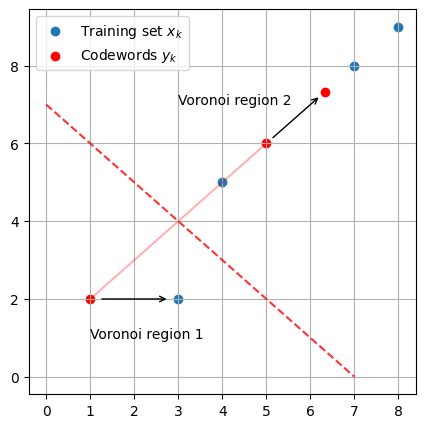

In [28]:
# Python Plot
plt.figure(figsize=(5,5))
train=np.array([[3,2], [4,5], [7,8],[8,9]])
codebooks = np.array([[1,2], [5,6]])
x_train, y_train = train.T
x_codebooks, y_codebooks = codebooks.T
plt.scatter(x_train, y_train, label='Training set $x_k$')
plt.scatter(x_codebooks, y_codebooks, label='Codewords $y_k$',color='r')
plt.legend()
plt.grid()
y=lambda x : -x+7
plt.plot([1,5],[2,6],color='r', alpha=0.3)
plt.scatter(6+1/3,7+1/3,color='r')
plt.plot(np.arange(0,8,1),y(np.arange(0,8,1)),'r--', alpha=0.8)
plt.text(1,1,'Voronoi region 1')
plt.text(3,7,'Voronoi region 2');
plt.annotate("", xy=(3-0.2,2), xytext=(1+0.2, 2), arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(6+1/3-0.1,7+1/3-0.1), xytext=(5+0.1, 6+0.1), arrowprops=dict(arrowstyle="->"));

4) Go back to step 2) and repeat the procedure until the result does not change much anymore.

### Vector Quantization in an Encoder and Decoder

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/0xBFErjdSgk" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

- Both, encoder and decoder, have the same codebook in their memory.<br>
- In an Encoder we first convert our signal sample stream to our vectors.<br>
- Then we map those vectors to the nearest code vectors.<br>
- We transmit the indices of those codevectors to the decoder.<br>
- The decoder converts the indices back to the codevectors.<br>
- The codevectors are then concatenated and converted back into a stream of samples.<br><br>

**Example:**
Encoder:<br>
stream to vectors:<br>
x: [3,4],[7,8],...<br>
Vectors to codevectors:<br>
y: [4,5],[6.7]<br>
to indices:<br>
k:    4,     5<br>
Decoder:<br>
Indices to vectors:<br>
y: [4,5],[6,7]<br>
to stream of samples:<br>
xrek: 4,5,6,7

### Python Example: Vector Quantization in an Encoder and Decoder

### Example for Gaussian noise as signal

In [29]:
# Create Codebook
import numpy as np
np.random.seed(seed=1)
from sklearn.cluster import KMeans

N =  3 #Number of bits
n_clusters = 2**N
training_signal=np.random.normal(0,0.3,3200)
training_data=training_signal.reshape(-1,2).astype('double')

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, max_iter=1000)
kmeans.fit(training_data)

KMeans(max_iter=1000, n_init=10)

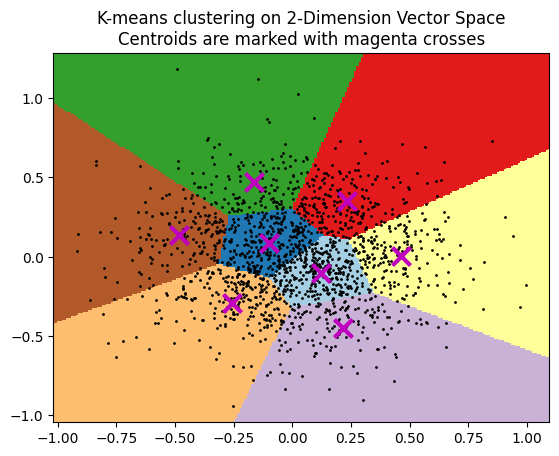

In [30]:
# Codebook and Voronoi Visualization
# Plot From(https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)
import matplotlib.pyplot as plt
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = training_data[:, 0].min() - 1, training_data[:, 0].max() + 1
y_min, y_max = training_data[:, 1].min() - 1, training_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(training_data[:, 0], training_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('K-means clustering on 2-Dimension Vector Space\n'
          'Centroids are marked with magenta crosses')
plt.xlim(x_min+0.9, x_max-0.9)
plt.ylim(y_min+0.9, y_max-0.9);
#plt.xticks(())
#plt.yticks(());

###Example for a music audio signal

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/dgMx8Sc4Eag" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

**Codebook**

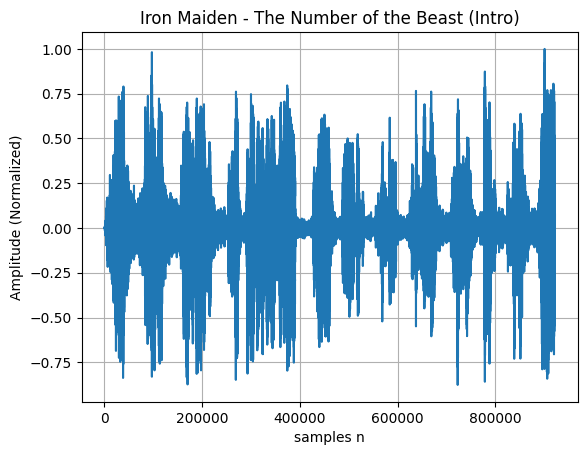

In [31]:
# Training Set
training_signal , sr = lbr.load(path+'/audio/Iron Maiden - Aces High.mp3', sr=Fs, offset=0, duration=28.8)
#Alternatively use Gaussian noise:
#training_signal=np.random.normal(0,0.3,3200)
#Fs=32000
# Normalize Audio
training_signal/=np.abs(training_signal).max()
# Plot Audio
plt.figure()
plt.plot(training_signal)
plt.title('Iron Maiden - The Number of the Beast (Intro)')
plt.xlabel('samples n')
plt.ylabel('Amplitude (Normalized)');
plt.grid()
# Listen
display(ipd.Audio(training_signal, rate = Fs ))

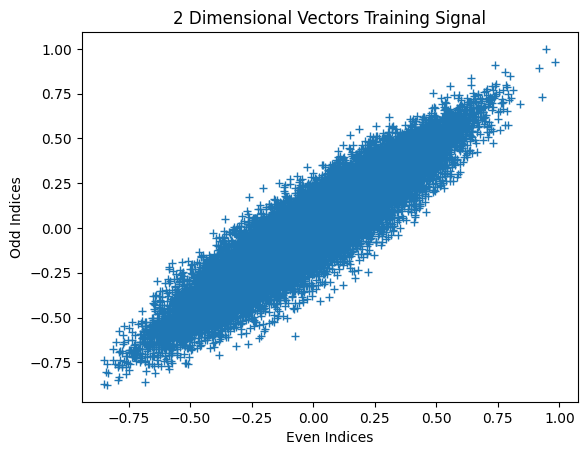

In [32]:
# 2-Dimensional Vector Space of Samples
plt.figure()
training_data=training_signal.reshape(-1,2).astype('double')
plt.plot(list(zip(*training_data))[0],list(zip(*training_data))[1],'+')
plt.title('2 Dimensional Vectors Training Signal')
plt.xlabel('Even Indices')
plt.ylabel('Odd Indices');

In [33]:
# Create Codebook
np.random.seed(seed=1)
from sklearn.cluster import KMeans

N =  3 #Number of bits per vector, here: signal sample pairs
n_clusters = 2**N

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, max_iter=1000)
kmeans.fit(training_data)

KMeans(max_iter=1000, n_init=10)

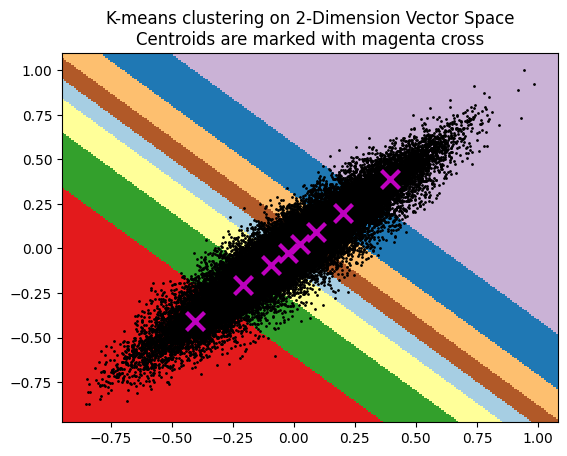

In [34]:
# Codebook and Voronoi Visualization
# Plot From(https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = training_data[:, 0].min() - 1, training_data[:, 0].max() + 1
y_min, y_max = training_data[:, 1].min() - 1, training_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(training_data[:, 0], training_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('K-means clustering on 2-Dimension Vector Space\n'
          'Centroids are marked with magenta cross')
plt.xlim(x_min+0.9, x_max-0.9)
plt.ylim(y_min+0.9, y_max-0.9);
#plt.xticks(())
#plt.yticks(());

In [35]:
# Codebook
centroids
codebook_dict = {ind : val for ind,val in enumerate(centroids.tolist())}
codebook_dict

{0: [-0.02312747393027431, -0.023211756441952405],
 1: [0.20178717764873877, 0.20158207966979447],
 2: [-0.20654087166387444, -0.20655941503177666],
 3: [-0.4057317081896744, -0.4056562080287263],
 4: [0.09237542585945001, 0.0924575774182731],
 5: [0.3922695415386609, 0.39286148070251964],
 6: [-0.09275931172500863, -0.09256313539750652],
 7: [0.02394395802611152, 0.023927485939849138]}

[4 1 5 1 4 4 4 1 4 6]


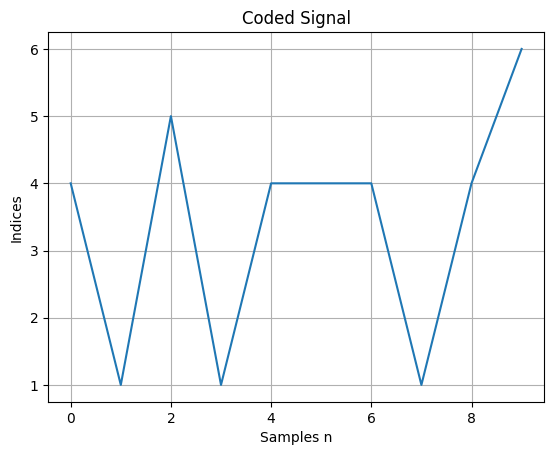

In [38]:
# Indices of Codewords
#k = kmeans.labels_
k = kmeans.predict(training_data)
plt.figure()
plt.plot(k[100000:100010])
print(k[100000:100010])
plt.grid()
plt.title('Coded Signal')
plt.ylabel('Indices')
plt.xlabel('Samples n');

**Decoder**

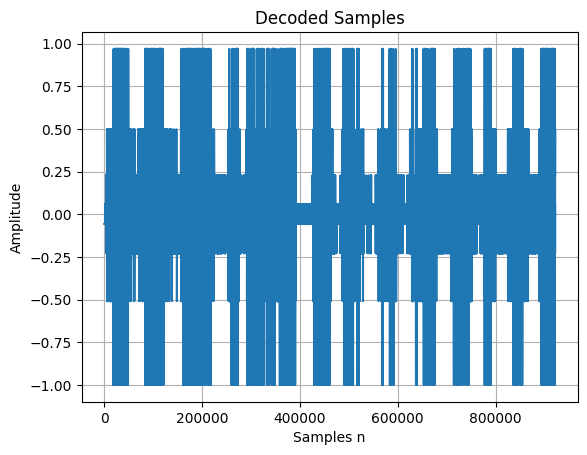

In [39]:
# Decode Indices to Vectors
decoded=np.array([codebook_dict[ind] for ind in k.tolist()])
decoded/=np.abs(decoded).max()

#Vectors to Stream of Samples
decoded=decoded.reshape(-1,)

# Plot Decoded Samples
plt.figure()
plt.plot(decoded)
plt.grid()
plt.title('Decoded Samples')
plt.xlabel('Samples n')
plt.ylabel('Amplitude');

# Listen to Decoded Samples
ipd.Audio(decoded, rate=Fs)

**Encode / Decode using Another Signal**

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/IYFwh5TUFtk" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

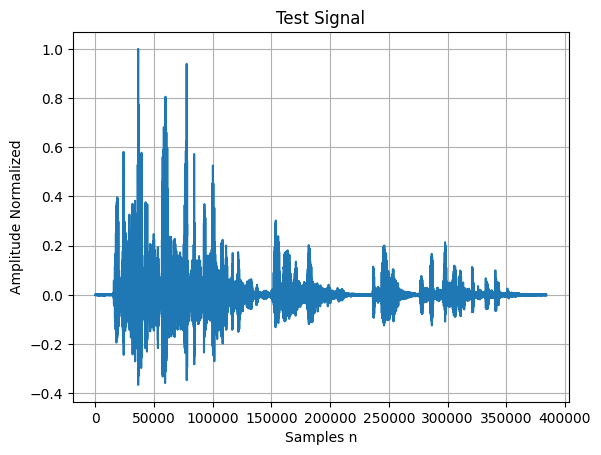

In [40]:
# Test Signal
test_signal , sr =lbr.load(path+'/audio/Iron Maiden - The Number Of The Beast.mp3', sr=Fs, offset=13, duration=12)
# Normalize Audio
test_signal/=np.abs(test_signal).max()
# Plot Test Signal
plt.figure()
plt.plot(test_signal)
plt.grid()
plt.title('Test Signal')
plt.xlabel('Samples n')
plt.ylabel('Amplitude Normalized')
# Listen to Test Signal
display(ipd.Audio(test_signal, rate=Fs))

Mid-Rise Quantizer

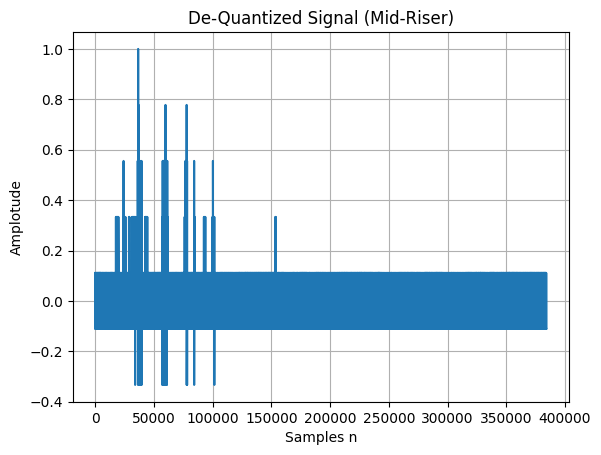

In [41]:
# Define Step Size
stepsize=(1.0-(-1.0))/(2**N) #N bits per sample, not per signal sample pair, hence twice as high bitrate as vector quantizer!
# Mid-Rise Quantization
speech_quant_rise_ind=np.floor(test_signal/stepsize)
# Mid-Rise De-Quantization
speech_quant_rise_rec=speech_quant_rise_ind*stepsize+stepsize/2
# Normalize
speech_quant_rise_rec/=np.abs(speech_quant_rise_rec).max()
# Plot De-Quantized Signal
plt.figure()
plt.plot(speech_quant_rise_rec)
plt.title('De-Quantized Signal (Mid-Riser)')
plt.xlabel('Samples n')
plt.ylabel('Amplotude')
plt.grid()
# Listen to De-Quantized Signal
ipd.display(ipd.Audio(speech_quant_rise_rec, rate=Fs))


Vector Quantization: Encoder

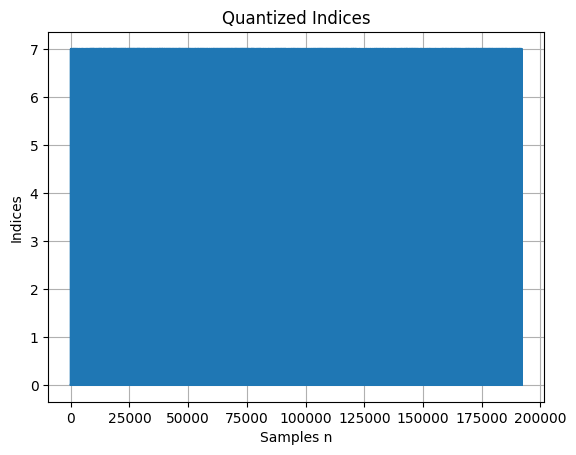

In [42]:
# Stream to Vectors
test_signal_vec=test_signal.reshape(-1,2).astype('double')
# Vectors to Indices
quantized = kmeans.predict(test_signal_vec)
# Plot Quantized Indices
plt.figure()
plt.plot(quantized)
plt.grid()
plt.title('Quantized Indices')
plt.ylabel('Indices')
plt.xlabel('Samples n');

Vector Quantization: Decoder

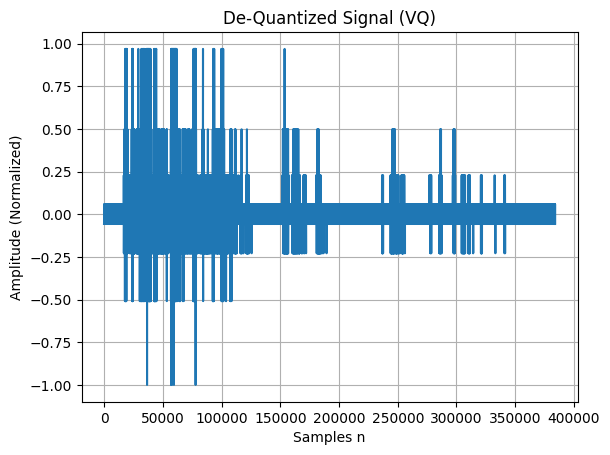

In [43]:
# Indices to Vectors
decoded=np.array([codebook_dict[ind] for ind in quantized.tolist()])
decoded/=np.abs(decoded).max()
# Vectors to Stream of Samples
decoded=decoded.reshape(-1,)
# Plot De-Quantized Signal
plt.figure()
plt.plot(decoded)
plt.grid()
plt.title('De-Quantized Signal (VQ)')
plt.xlabel('Samples n')
plt.ylabel('Amplitude (Normalized)')
# Listen to de-Quantized Signal
ipd.Audio(decoded, rate=Fs)

Quantization Error

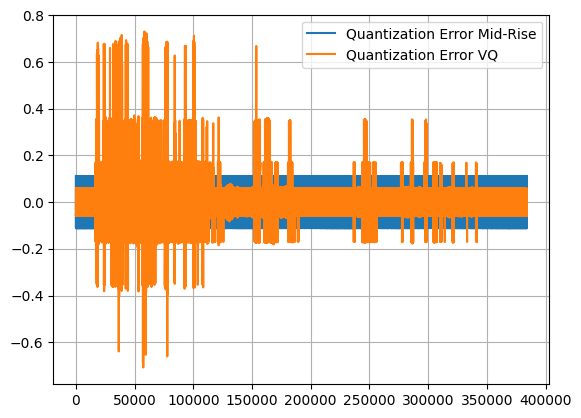

In [44]:
quant_error_rise = speech_quant_rise_rec - test_signal
quant_error_vq = decoded - test_signal
plt.figure()
plt.plot(quant_error_rise, label='Quantization Error Mid-Rise')
plt.plot(quant_error_vq, label='Quantization Error VQ')
plt.legend()
plt.grid()

In [ ]:
print('Mean Squared Quantization Error - Mid-Riser:',((speech_quant_rise_rec - test_signal)**2).mean())
print('Mean Squared Quantization Error - VQ:',(((decoded - test_signal)**2)**2).mean())
#Keep in mind: scalar quantizer has twice as high bitrate!

Mean Squared Quantization Error - Mid-Riser: 0.009268379
Mean Squared Quantization Error - VQ: 0.0003092007330044081
